# Lectura de matrices
En este archivo leemos las matrices y realizamos los respectivos calculos sobre ellas y observamos los resultados

In [1]:
import math, subprocess
import pandas as pd
import numpy as np
import random, math
import os
import shutil
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import sys
from IPython.display import display, clear_output
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# Constantes necesarias
path_instancias_karate = F"./instancias"
path_karate = F"{path_instancias_karate}/karateclub_analisis"

In [3]:
# Constantes necesarias
path_instancias_facebook = F"./instancias"
path_egofacebook = F"{path_instancias_facebook}/ego-facebook-analisis"
path_egofacebook_edge = F"{path_egofacebook}/ego-facebook.edges"
path_egofacebook_feat = F"{path_egofacebook}/ego-facebook.feat"

## Metodo de la potencia

### Implementación en Python

In [4]:
def power_iteration(A, niter, eps):
    b = np.random.rand(A.shape[1])
    b = b / np.linalg.norm(b)
    for i in range(niter):
        old = b
        b = A @ b
        norm = np.linalg.norm(b)
        b = b / norm
        cos_angle = np.dot(b, old)
        if (1 - eps) < cos_angle <= 1:
            break
    Ab = A @ b
    eigenvalue = np.dot(b, Ab)
    return eigenvalue, b

In [5]:
def eig(A, niter, eps):
    A_aux = A.copy()
    eigenvalues = []
    eigenvectors = np.zeros((A_aux.shape[0], A.shape[0]))
    
    for i in range(0, len(A)):
        l, v = power_iteration(A, niter, eps)

        eigenvalues.append(l)
        eigenvectors[:, i] = v
        A = A - l * np.outer(v, v)
        
    return np.array(eigenvalues), eigenvectors

### Ejecución de la implementación en C++

In [6]:
def correr_metodo_potencia(archivo, iteraciones, convergencia):
    process = subprocess.Popen(
        ["./metodo_potencia", archivo, str(iteraciones), str(convergencia)], 
        stderr=subprocess.PIPE, 
        stdout=subprocess.PIPE, 
        stdin=subprocess.PIPE, 
        universal_newlines = True)
    exit_code = process.wait()
    if exit_code != 0: 
        print(F"Hubo un error en la experimentacion con la instancia {archivo_instancia}")
        
    process.stdin.close();
    process.stdout.close();
    process.stderr.close();

## Lectura de matrices y escritura de matrices y resultados

In [7]:
def leer_matriz_completa(path_instancia):
    matrix = np.loadtxt(path_instancia, dtype='i', delimiter=' ')
    return matrix

In [8]:
def leer_matriz_columnas(path_instancia):
    with open(path_instancia,'rt') as filedata:
        values = np.genfromtxt(path_instancia, dtype=None, unpack=True)
    return values

In [9]:
def leer_matriz_relaciones(path_instancia):
    return np.genfromtxt(path_instancia, dtype=None, delimiter=' ')

In [10]:
def leer_columna_matriz(path_instancia):
    return np.loadtxt(path_instancia)

In [11]:
def imprimir_matriz(path_dir, name_file, matriz):
    with open(F"{path_dir}/{name_file}", "w") as f:
        for i in range(0, len(matriz)):
            for j in range(0, len(matriz)):
                print(matriz[i][j], file=f, end=" ")
            print(file=f, end="\n")

In [12]:
def leer_matriz_adyacencia(path_instancia_edge):
    matriz_columnas = leer_matriz_columnas(path_instancia_edge)
    columna_zero = matriz_columnas[0]
    columna_uno = matriz_columnas[1]

    return [columna_zero, columna_uno]

In [13]:
def leer_matriz_features(path_instancia_feat):
    matrix = leer_matriz_completa(path_instancia_feat)
    nodos = matrix[:, 0]
    atributos = matrix[:, 1:]
    
    return [nodos, atributos]

### Precomputo de Facebook

In [14]:
def limpiar_atributos(c_uno, c_dos, nodos):
    # Recorro los nodos y las columnas
    for i in range(0, len(nodos)):
        esta = False
        if nodos[i] != -1:
            for j in range(0, len(c_uno)):
                if nodos[i] == c_uno[j]:
                    esta = True
                if nodos[i] == c_dos[j]:
                    esta = True
            if not esta:
                nodos[i] = -1
    return nodos

In [15]:
def limpiar_adyacencia(c_uno, c_dos, nodos):
    for i in range(0, len(c_uno)):
        esta = False
        if c_uno[i] != -1:
            for j in range(0, len(nodos)):
                if c_uno[i] == nodos[j]:
                    esta = True
            if not esta:
                c_uno[i] = -1
            
    for i in range(0, len(c_dos)):
        esta = False
        if c_dos[i] != -1:
            for j in range(0, len(nodos)):
                if c_dos[i] == nodos[j]:
                    esta = True
            if not esta:
                c_dos[i] = -1
    
    return [c_uno, c_dos]

In [16]:
def limpiar_inexistentes(cUno, cDos, nodos):
    nodos = limpiar_atributos(cUno, cDos, nodos)
    (cUno, cDos) = limpiar_adyacencia(cUno, cDos, nodos)
    nodos = limpiar_atributos(cUno, cDos, nodos)
    
    return [nodos, cUno, cDos]

In [17]:
def limpiar_listas(cUno, cDos, nodos, atributos):
    aux_nodos = []
    aux_atributos = []
    for i in range(0, len(nodos)):
        if nodos[i] != -1:
            aux_nodos.append(nodos[i])
            aux_atributos.append(atributos[i])
    
    aux_cUno = []
    aux_cDos = []
    for i in range(0, len(cUno)):
        if cUno[i] != -1 and cDos[i] != -1:
            aux_cUno.append(cUno[i])
            aux_cDos.append(cDos[i])
            
    return [aux_nodos, aux_atributos, aux_cUno, aux_cDos]

In [18]:
def armar_adyacencia(cUno, cDos):
    lista_adyacencias = []
    for i in range(0, len(cUno)):
        lista_adyacencias.append(F"{cUno[i]} {cDos[i]}")
    G_aux = nx.parse_adjlist(lista_adyacencias)
    return G_aux

In [19]:
def limpiar_matriz(path_instancia_feat, path_instancia_edge):
    (nodos, atributos) = leer_matriz_features(path_instancia_feat)
    (cUno, cDos) = leer_matriz_adyacencia(path_instancia_edge)
    (nodos, cUno, cDos) = limpiar_inexistentes(cUno, cDos, nodos)
    (nodos, atributos, cUno, cDos) = limpiar_listas(cUno, cDos, nodos, atributos)
    return [nodos, atributos, cUno, cDos]

In [20]:
def precomputar_matriz(path_instancia_feat, path_instancia_edge):
    (nodos, atributos, cUno, cDos) = limpiar_matriz(path_instancia_feat, path_instancia_edge)
    G_ady = armar_adyacencia(cUno, cDos)
    nodos_txt = []
    for item in nodos:
        nodos_txt.append(str(item))
    M_ady = nx.to_numpy_array(G_ady, nodelist=nodos_txt)
    atributos = np.array(atributos)
    return [M_ady, nodos, atributos]

## Funciones necesarias para el analisis

In [21]:
def laplaciana(A):
    D = np.zeros((len(A), len(A)), dtype=np.float64)
    for i in range(0, len(D)):
        suma = 0
        for j in range(0, len(D)):
            suma += A[i][j]
        D[i][i] = suma
    return D - A

In [22]:
def minimo_mayor_zero(v):
    min_val = v[0]
    min_pos = 0
    for i in range(0, len(v)):
        if v[i] < min_val and v[i] > 0:
            min_val = v[i]
            min_pos = i
        
    return [min_val, min_pos]

In [23]:
def maximo(v):
    max_val = v[0]
    max_pos = 0
    for i in range(0, len(v)):
        if v[i] > max_val:
            max_val = v[i]
            max_pos = i
            
    return [max_val, max_pos]

In [24]:
def maximo_en_tupla(arr):
    num = 0
    for i in range(0, len(arr)):
        if arr[i][0] > num:
            num = arr[i][0]
        if arr[i][1] > num:
            num = arr[i][1]
    return num

In [25]:
def centralidad_autovector(A, eigenvalues, eigenvectors):
    central = np.zeros(eigenvectors[0].shape)
    
    # Obtengo el maximo autovalor y su posición
    max_res = maximo(eigenvalues)
    # Obtengo el autovector asociado al máximo autovalor usando la posición
    eigenvector = eigenvectors[max_res[1]]
    eigenvalue = max_res[0]
    
    for i in range(0, len(central)):
        suma = 0
        for j in range(0, len(central)):
            suma += A[i][j]*eigenvector[j]
        central[i] = (1/eigenvalue) * suma
    return central

#### Covarianza entre los vectores X e Y definida como;
$Cov(X, Y) = \frac{(X - \mu_x)(Y - \mu_y)}{n-1}$

In [26]:
def covarianza(x, y):
    n = x.shape
    sum_val = 0
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    
    for i in range(0, len(x)):
        sum_val += (x[i] - mu_x) * (y[i] - mu_y)
    
    cov = (1/(n-1))*sum_val
    return cov

#### Correlacion entre los vectores X e Y definida como;
$Cov(X, Y) = \frac{(X - \mu_x)(Y - \mu_y)}{\sqrt{(X - \mu_x)(X - \mu_x)}\sqrt{(Y - \mu_y)(Y - \mu_y)}}$

In [27]:
def correlacion(x, y):
    n = x.shape
    sum_num = 0
    sum_dem_a = 0
    sum_dem_b = 0
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    
    for i in range(0, len(x)):
        op_x_mu = (x[i] - mu_x)
        op_y_mu = (y[i] - mu_y)

        sum_num += (op_x_mu)*(op_y_mu)
        sum_dem_a += (op_x_mu)**2
        sum_dem_b += (op_y_mu)**2
        
    sum_dem = (math.sqrt(sum_dem_a))*(math.sqrt(sum_dem_b))
    cor = 0
    if sum_dem != 0:
        cor = sum_num / sum_dem
    return cor

#### Conectividad algebraica definida como:
$min(\lambda \geq 0)$  con $\lambda$ autovector de la matriz laplaciana L

In [28]:
def conectividad_algebraica(eigenvalues, eigenvectors):
    minimo = minimo_mayor_zero(eigenvalues)
    return [minimo[0], eigenvectors[minimo[1]]]

#### Matriz de covarianza
$C = \frac{X^tX}{n-1}$

In [29]:
def matriz_covarianza(matriz):
    mat_aux = []
    rows = len(matriz)
    cols = len(matriz[0])
    AUX = []
    
    for col in range(0, cols):
        # Itero sobre las columnas de matriz
        # Digo: Parate en la columna i y dame todos los elementos, iterando por toda la fila
        col_i = []
        for row in range(0, rows):
            col_i.append(matriz[row][col])
        # Aca ya tengo en un arreglo toda la columna. Ahora le busco su media
        median = np.mean(col_i)
        
        # Ahora a cada posición de la columna le resto la media
        for pos in range(0, len(col_i)):
            col_i[pos] = (col_i[pos] - median)
        
        # Ya tengo la columna - media, entonces lo guardo en AUX como fila
        AUX.append(col_i)
        # Repito por cada columna
        
    # Tengo AUX como una lista, lo convierto en una matriz ese será el X
    X = (np.array(AUX))
    # Saco su traspuesta
    XT = X.T
        
    # Ahora armo C
    C= np.matmul(XT, X) / (cols-1)
    
    return [X, C]

#### Matriz de similaridad:
$D = XX^t$

In [30]:
def matriz_similaridad(matrix):
    XT = matrix.transpose()
    X = matrix
    return np.matmul(X, XT)

In [31]:
def abs_val(num):
    if num < 0:
        return (-1)*num
    return num

In [32]:
def normalizar(v):
    return v / np.linalg.norm(v)

# Evaluamos el Karate Club
- Primero construimos D, la matriz diagonal.
- A lo obtenemos de leer la matriz.
- Construimos la matriz Laplaciana.

Primero vamos a trabajar con la matriz de adyacencias
- Leemos la matriz
- Corremos el metodo de la potencia y conseguimos autovalores y autovectores
- Con eso conseguimos el vector de centralidad y lo normalizamos

In [33]:
# Leemos la matriz de carate
A = leer_matriz_completa('./instancias/karateclub_analisis/karateclub_matriz.txt')

# Le evaluamos sus autovalores y autovectores y los obtenemos
correr_metodo_potencia(F"{path_karate}/karateclub_matriz.txt", 1000, 1e-6)

eigenvalues_karate = leer_columna_matriz(F"{path_karate}/karateclub_matriz.txt-autovalores.out")
eigenvectors_karate = leer_matriz_columnas(F"{path_karate}/karateclub_matriz.txt-autovectores.out")

# Obtengo el vector de centralidad
central_autovector = centralidad_autovector(A, eigenvalues_karate, eigenvectors_karate)

# Vector de centralidad normalizado
central_autovector_normalizado = normalizar(central_autovector)

In [34]:
karate_labels = leer_columna_matriz(F"{path_karate}/karateclub_labels.txt")

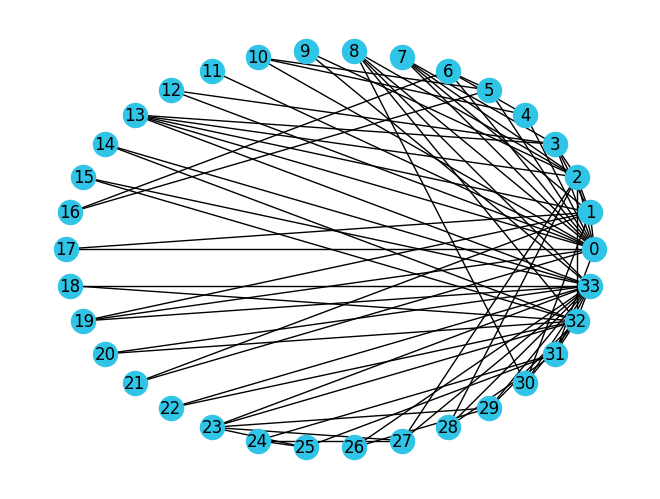

In [35]:
# Imprimimos A para ver que pinta tiene
G = nx.from_numpy_array(A)
nx.draw_circular(G, with_labels=True, node_color='#30c4e6')
plt.savefig("graficos/karateclub-relaciones.svg", format="SVG")

In [36]:
# Obtengo los 5 nodos más relevantes e influyentes
nodos_relevantes = []
index_arr = sorted(range(len(central_autovector)), key=lambda i: central_autovector[i], reverse=True)[:5]
for i in index_arr:
    # print(F"Nodo {i} : {central_autovector[i]}")
    nodos_relevantes.append([F"{i}", central_autovector[i]])
    
df_nodos_relevantes = pd.DataFrame(nodos_relevantes, columns=["Nodo", "Centralidad"]);
df_nodos_relevantes

,Nodo,Centralidad
0,33,0.373841
1,0,0.355246
2,2,0.317086
3,32,0.309011
4,1,0.265761


Hagamos una impresion del grafo en relación a su centralidad de los nodos usando el vector normalizado.

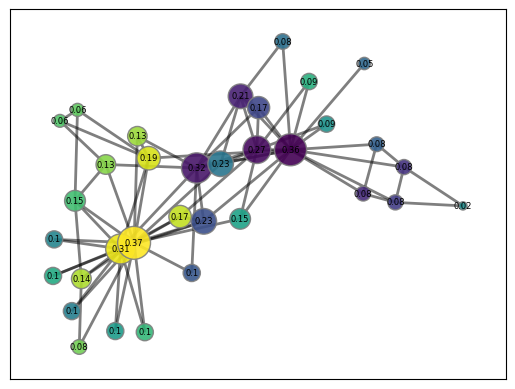

In [37]:
G_Centrality = nx.from_numpy_matrix(A) 
pos = nx.spring_layout(G_Centrality)
edges = G_Centrality.edges()

# central_autovector_normalizado
node_sizes = []
for v in central_autovector_normalizado:
    node_sizes.append(1500*v)

nodes = G_Centrality.nodes()
    
colors = [i/len(G.nodes) for i in range(len(G.nodes))]

options = {"edgecolors": "tab:gray", "node_size": node_sizes, "alpha": 0.9}
nx.draw_networkx_nodes(G_Centrality, pos, nodelist=nodes, node_color=colors, **options)

nx.draw_networkx_edges(G,pos, edgelist=edges, width=2,alpha=0.5)
labels = {}
for i in range(0, len(central_autovector_normalizado)):
    value = str(round(central_autovector_normalizado[i], 2))
    labels[i] = value
    
nx.draw_networkx_labels(G, pos, labels, font_size=6, font_color="black")

plt.savefig("graficos/karateclub-centralidad.svg", format="SVG")

Representamos con un gráfico de barras los valores

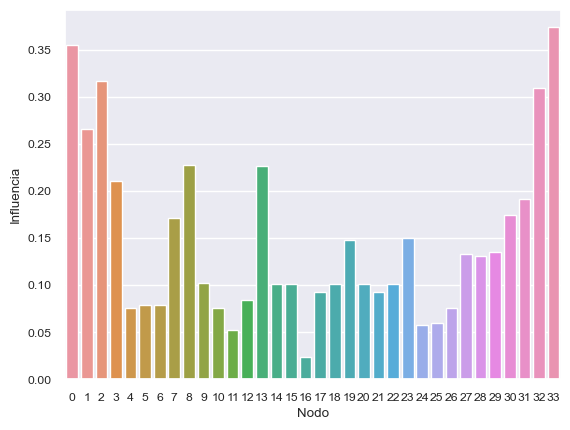

In [38]:
influencia_nodos = []
for i in range(0, len(central_autovector_normalizado)):
    influencia_nodos.append([i, central_autovector_normalizado[i]])

df_influencias = pd.DataFrame(influencia_nodos, columns=["Nodo", "Influencia"]);

name = F"Influencia de las páginas"

sns.set(font_scale = 0.8)
fig = sns.barplot(
    data=df_influencias, 
    x='Nodo', 
    y='Influencia'
);

fig.set(xlabel='Nodo', ylabel='Influencia');
plt.savefig("graficos/referenciadas-influencia-barras.svg", bbox_inches = 'tight');

Este grafo nos da una idea sobre como se podrían ir separando los grupos dada la influencia.
Aquellos colores más cercanos a lso amarillos son un grupo mientras los más cercanos al violeta son otros.
Los más cercanos al azul no podriamos dar una conclusión fija, todo dependería de que color contenga más en su composición ya sea, amarillo o violeta.

Ahora trabajamos con la laplaciana
- Construimos la matriz laplaciana
- Corremos el metodo de la potencia y conseguimos autovalores y autovectores

In [39]:
L = laplaciana(A)

# Convertimos la laplaciana en un .txt para,
# posteriormente ejecutar el algoritmo del metodo de la potencia y obtener los valores buscados.
imprimir_matriz(path_karate, "laplaciana.txt", L)

# Ejecutamos el metodo de la potencia con deflación
correr_metodo_potencia(F"{path_karate}/laplaciana.txt", 1000, 1e-6)

# Obtenemos autovalores y autovectores
eigenvalues_laplaciana = leer_columna_matriz(F"{path_karate}/laplaciana.txt-autovalores.out")
eigenvectors_laplaciana = leer_matriz_columnas(F"{path_karate}/laplaciana.txt-autovectores.out")

Por ultimo nos queda estudiar la laplaciana con la de adyacencias
Para ello:
- Tenemos que conseguir la predicción con los autovectores de la laplaciana
- Para tal motivo uso la matriz de los labels de karate y voy a calcular su correlación respecto de los autovectores de la matriz laplaciana

In [40]:
correlaciones = []
for v in eigenvectors_laplaciana:
    cor = correlacion(karate_labels, v)
    correlaciones.append(abs_val(cor))

In [41]:
print(correlaciones)

[0.045427935451860454, 0.01217888031905231, 0.07878593614152232, 0.05869931157510676, 0.08450222568336359, 0.011300946672993585, 0.0781444916402773, 0.019154393064976453, 0.0075910591754665465, 0.2439853098678195, 0.08465191855324049, 0.03933149359476138, 0.01178055632141709, 0.002927658756208471, 0.06646637825369316, 0.016281298030175917, 0.08363504723040091, 0.005815180285737054, 0.1603054744346447, 0.11957793291550682, 0.0006688387195636009, 0.0011809662810314079, 0.0008360611214562263, 0.00046019460837873, 0.000694914588023899, 0.010969427856816306, 0.06976786497518828, 0.025038989978251196, 0.05539307151213096, 0.0038028389847958683, 0.33480040784026494, 0.264491081816214, 0.8141336639768862, 0.04536595460775637]


Analicemos las correlaciones y comparemos con el vector de centralidad

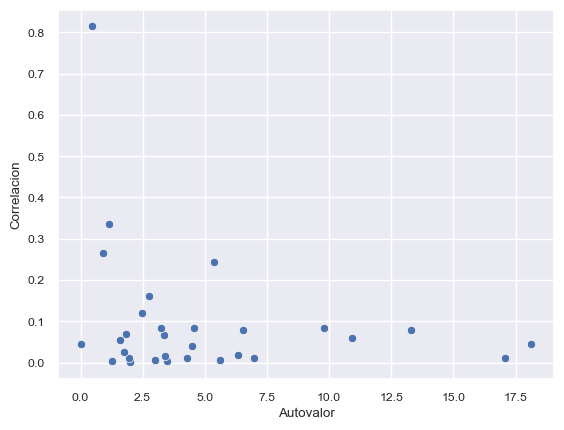

In [42]:
correlacion_centralidad = []
numero_autovalor = []
for i in range(0, len(correlaciones)):
    # print(F"Autovalor {i}: {eigenvalues_laplaciana[i]} con correlacion {correlaciones[i]}")
    correlacion_centralidad.append([eigenvalues_laplaciana[i], correlaciones[i], i])
    numero_autovalor.append(i)

df_centralidad_correlacion = pd.DataFrame(correlacion_centralidad, columns=["Autovalor", "Correlacion", "Indice"]);

fig = sns.scatterplot(
    data=df_centralidad_correlacion, 
    x='Autovalor', 
    y='Correlacion',

);

fig.set(xlabel='Autovalor', ylabel='Correlacion');
plt.savefig("graficos/referenciadas-correlacion-influencia.svg", bbox_inches = 'tight');

In [43]:
# Obtengo el de mayor correlacion
index_cor = sorted(range(len(correlaciones)), key=lambda i: correlaciones[i], reverse=True)[:5]
print(F"Posición {index_cor[0]} con correlación: {correlaciones[index_cor[0]]}")
print(F"Autovalor: {eigenvalues_laplaciana[index_cor[0]]}")
print(F"Autovector: {eigenvectors_laplaciana[index_cor[0]]}")

Posición 32 con correlación: 0.8141336639768862
Autovalor: 0.468526
Autovector: [-0.111983  -0.0410775  0.0233131 -0.0552657 -0.284875  -0.324177
 -0.324177  -0.0523619  0.0516333  0.0928287 -0.284875  -0.209269
 -0.109106  -0.0145882  0.162615   0.162615  -0.42359   -0.0998478
  0.162615  -0.0134932  0.162615  -0.0998478  0.162615   0.15556
  0.152879   0.160799   0.186909   0.127583   0.0951369  0.167494
  0.0735301  0.0986906  0.130261   0.11884  ]


Como podemos observar, tenemos que el anteultimo autovector de la matriz laplaciana es el que mejor predice. Veamos que nos dice el numero algebraico

In [44]:
numero_algebraico = conectividad_algebraica(eigenvalues_laplaciana, eigenvectors_laplaciana)

In [45]:
# Podemos uasr este vector para decir que nodos pertenecen a un grupo y que a otros
# Para ello uso dos vectores distintos
grupo_zero = []
grupo_uno = []
# Con esto, recorro el autovector y me quedo con los valores negativos para el grupo 0 y los positivos para el grupo 1
fiedler_vector = numero_algebraico[1]
for i in range(0, len(fiedler_vector)):
    if fiedler_vector[i] < 0:
        grupo_zero.append(i)
    else:
        grupo_uno.append(i)

Vemos como quedaron los grupos

In [46]:
print(grupo_zero)

[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]


In [47]:
print(grupo_uno)

[2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


#### Aca tenemos nuestros resultados, nuestro numero algebraico y el vector de Fiedler

In [48]:
print(F"Numero algebraico: {numero_algebraico[0]}")

Numero algebraico: 0.468526


In [49]:
print("Fiedler Vector:")
print(numero_algebraico[1])

Fiedler Vector:
[-0.111983  -0.0410775  0.0233131 -0.0552657 -0.284875  -0.324177
 -0.324177  -0.0523619  0.0516333  0.0928287 -0.284875  -0.209269
 -0.109106  -0.0145882  0.162615   0.162615  -0.42359   -0.0998478
  0.162615  -0.0134932  0.162615  -0.0998478  0.162615   0.15556
  0.152879   0.160799   0.186909   0.127583   0.0951369  0.167494
  0.0735301  0.0986906  0.130261   0.11884  ]


#### Aca tenemos el vector de Fiedler pero desde NetworkX

In [50]:
G = nx.from_numpy_matrix(A)
fiedler_vector_nx = nx.fiedler_vector(G)
print(fiedler_vector_nx)

[-0.11213742 -0.04128787  0.02321896 -0.05549977 -0.28460454 -0.32372725
 -0.32372725 -0.05258599  0.05160128  0.09280089 -0.28460454 -0.21099285
 -0.10946127 -0.01474196  0.16275078  0.16275078 -0.42276538 -0.1001814
  0.16275078 -0.01363712  0.16275078 -0.1001814   0.16275078  0.15569456
  0.15302557  0.16096291  0.18710955  0.12766404  0.0951523   0.1676503
  0.07349964  0.09875342  0.13034545  0.11890326]


<class 'networkx.utils.decorators.argmap'> compilation 25:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Y coincide la prediccion! El autovector dado por la mayor correlación y el numero algebraico coincide! Inclusive, usando el vector de fiedler dado por NetworkX. Usaremos esto como medida.

Vemos que tenemos casi lo mismo, ahora podemos graficar perfectamente dos grupos.

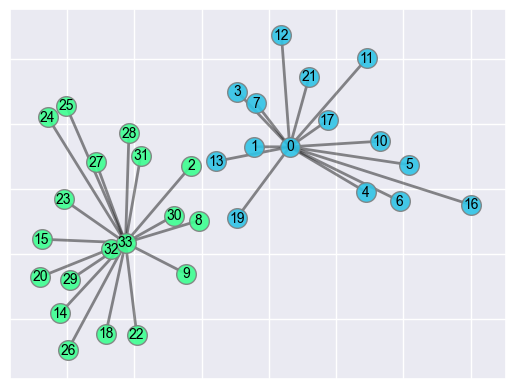

In [51]:
E = np.zeros(A.shape)

grupo_zero_edges = []
for item in grupo_zero:
    if item != 0:
        E[0][item] = 1
        E[item][0] = 1
        grupo_zero_edges.append((0, item))
    
grupo_uno_edges = []
for item in grupo_uno:
    if item != 33:
        E[33][item] = 1
        E[item][33] = 1
        grupo_uno_edges.append((33, item))

G_E = nx.from_numpy_matrix(E)
#nx.draw_spring(G_E, with_labels=True, node_color='#30c4e6')
edges = G_E.edges()

options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.9}
nx.draw_networkx_nodes(G_E,pos, nodelist=grupo_zero, node_color='#30c4e6', **options)
nx.draw_networkx_nodes(G_E,pos, nodelist=grupo_uno, node_color='#3dff91', **options)

nx.draw_networkx_edges(G_E,pos, edgelist=grupo_zero_edges, width=2,alpha=0.5)
nx.draw_networkx_edges(G_E,pos, edgelist=grupo_uno_edges, width=2,alpha=0.5)

labels = {}
for i in range(0, len(central_autovector_normalizado)):
    labels[i] = i
nx.draw_networkx_labels(G_E, pos, labels, font_size=10, font_color="black")

plt.savefig("graficos/karateclub-separaciongrupos-prediccion.svg", format="SVG")

Comparemos con el valor real de los grupos a ver que ocurre

In [52]:
karate_labels
grupo_zero_labels = []
grupo_uno_labels = []
for i in range(0, len(karate_labels)):
        if int(karate_labels[i]) == 0:
            grupo_zero_labels.append(i)
        else:
            grupo_uno_labels.append(i)

In [53]:
print(F"Pertenecientes al grupo Zero real: {grupo_zero_labels}")
print(F"Pertenecientes al grupo Zero prediccion: {grupo_zero}")
zero_intersection = list(set(grupo_zero_labels) & set(grupo_zero))
zero_difference = list(set(grupo_zero_labels) - set(grupo_zero))
print(F"Interseccion entre grupo real y prediccion: {zero_intersection}")
print(F"Diferencia entre grupo real y prediccion: {zero_difference}")

Pertenecientes al grupo Zero real: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]
Pertenecientes al grupo Zero prediccion: [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Interseccion entre grupo real y prediccion: [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Diferencia entre grupo real y prediccion: [8, 2]


In [54]:
print(F"Pertenecientes al grupo Uno real: {grupo_uno_labels}")
print(F"Pertenecientes al grupo Uno prediccion: {grupo_uno}")
uno_intersection = sorted(list(set(grupo_uno_labels) & set(grupo_uno)))
uno_difference = sorted(list(set(grupo_uno) - set(grupo_uno_labels)))
print(F"Interseccion entre grupo real y prediccion: {uno_intersection}")
print(F"Diferencia entre grupo real y prediccion: {uno_difference}")

Pertenecientes al grupo Uno real: [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Pertenecientes al grupo Uno prediccion: [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Interseccion entre grupo real y prediccion: [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Diferencia entre grupo real y prediccion: [2, 8]


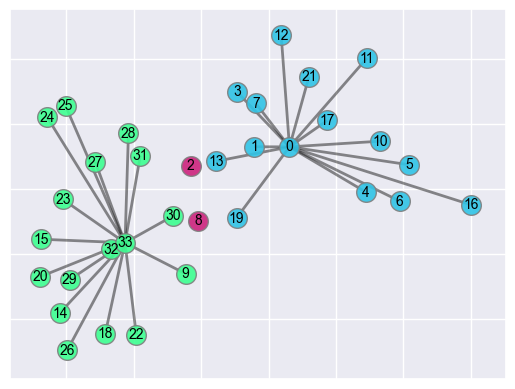

In [55]:
E_A = np.zeros(A.shape)

grupo_zero_interseccion_edges = []
for item in zero_intersection:
    if item != 0:
        E_A[0][item] = 1
        E_A[item][0] = 1
        grupo_zero_interseccion_edges.append((0, item))
    
grupo_uno_interseccion_edges = []
for item in uno_intersection:
    if item != 33:
        E_A[33][item] = 1
        E_A[item][33] = 1
        grupo_uno_interseccion_edges.append((33, item))

G_E_A = nx.from_numpy_matrix(E_A)
#nx.draw_spring(G_E, with_labels=True, node_color='#30c4e6')
edges = G_E_A.edges()

options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.9}
nx.draw_networkx_nodes(G_E_A,pos, nodelist=zero_intersection, node_color='#30c4e6', **options)
nx.draw_networkx_nodes(G_E_A,pos, nodelist=uno_intersection, node_color='#3dff91', **options)

nx.draw_networkx_nodes(G_E_A,pos, nodelist=uno_difference, node_color='#cc237d', **options)


nx.draw_networkx_edges(G_E_A,pos, edgelist=grupo_zero_interseccion_edges, width=2,alpha=0.5)
nx.draw_networkx_edges(G_E_A,pos, edgelist=grupo_uno_interseccion_edges, width=2,alpha=0.5)

labels = {}
for i in range(0, len(central_autovector_normalizado)):
    labels[i] = i
nx.draw_networkx_labels(G_E_A, pos, labels, font_size=10, font_color="black")

plt.savefig("graficos/karateclub-separaciongrupos-prediccion-interseccion.svg", format="SVG")

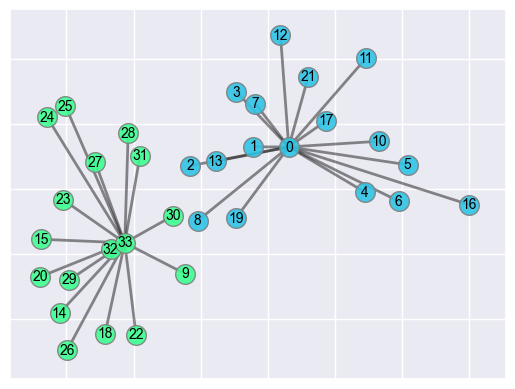

In [56]:
E_R = np.zeros(A.shape)

grupo_zero_real_edges = []
for item in grupo_zero_labels:
    if item != 0:
        E_A[0][item] = 1
        E_A[item][0] = 1
        grupo_zero_real_edges.append((0, item))
    
grupo_uno_real_edges = []
for item in grupo_uno_labels:
    if item != 33:
        E_A[33][item] = 1
        E_A[item][33] = 1
        grupo_uno_real_edges.append((33, item))

G_E_R = nx.from_numpy_matrix(E_A)
#nx.draw_spring(G_E, with_labels=True, node_color='#30c4e6')
edges = G_E_R.edges()

options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.9}
nx.draw_networkx_nodes(G_E_R,pos, nodelist=grupo_zero_labels, node_color='#30c4e6', **options)
nx.draw_networkx_nodes(G_E_R,pos, nodelist=grupo_uno_labels, node_color='#3dff91', **options)

nx.draw_networkx_edges(G_E_R,pos, edgelist=grupo_zero_real_edges, width=2,alpha=0.5)
nx.draw_networkx_edges(G_E_R,pos, edgelist=grupo_uno_real_edges, width=2,alpha=0.5)

labels = {}
for i in range(0, len(central_autovector_normalizado)):
    labels[i] = i
nx.draw_networkx_labels(G_E_R, pos, labels, font_size=10, font_color="black")

plt.savefig("graficos/karateclub-separaciongrupos-real.svg", format="SVG")

# Evaluamos la matriz de facebook

Lo primero que hacemos es leer ambas matrices, la de adyacencias y la de atributos. Cuando tenemos la de atributos calculamos la matriz de similaridad para obtener una matriz cuadrada que en cada posición tenga la cantidad de atributos que comparte con los demás nodos.

In [57]:
path_egofacebook_edge = F"{path_egofacebook}/ego-facebook.edges"
path_egofacebook_feat = F"{path_egofacebook}/ego-facebook.feat"

"""
M_Ady: Matriz de adyacencia de lista de adyacencias
nodos: Nodos de ambas matrices
atributos: Matriz de atributos
"""
(M_ady, nodos, atributos) = precomputar_matriz(path_egofacebook_feat, path_egofacebook_edge)

In [58]:
# Busco la matriz de similaridad de la matriz de atributos, o sea, matriz_features
fb_similaridad = matriz_similaridad(atributos)

Obtenida la matriz de similaridad, proponemos un umbral para el cual construiremos uuna nueva matríz que tendrá $1$ si el valor en la posicion $(i, j)$ supera ese umbral y $0$ si no. Luego, armamos un grafo para tener una visualización del mismo.

Procedemos entonces a tomar como umbral el valor $4$, ¿porque? No hay porque

In [59]:
def estimar_facebook(mat_similaridad, u):
    fb_A = np.zeros(mat_similaridad.shape, dtype=int)
    for i in range(0, len(mat_similaridad)):
        for j in range(0, len(mat_similaridad)):
            if i != j:
                if mat_similaridad[i][j] > u:
                    fb_A[i][j] = 1
    return fb_A

In [60]:
umbral = 4
fb_E = estimar_facebook(fb_similaridad, umbral)

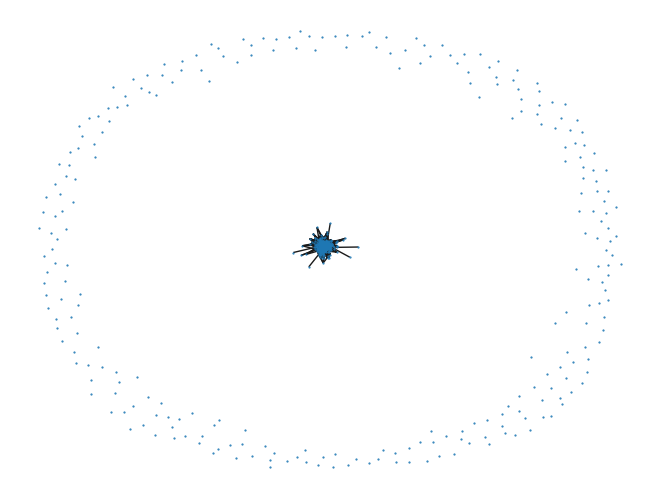

In [79]:
seed = 20160
G_umbral = nx.from_numpy_matrix(fb_E) 
pos = nx.spring_layout(G_umbral, seed=seed)  # Seed for reproducible layout
nx.draw(G_umbral, pos, node_size=0.3)
plt.savefig("graficos/relaciones-umbral-4.svg", format="SVG")

In [84]:
umbral = 25
fb_E_null = estimar_facebook(fb_similaridad, umbral)

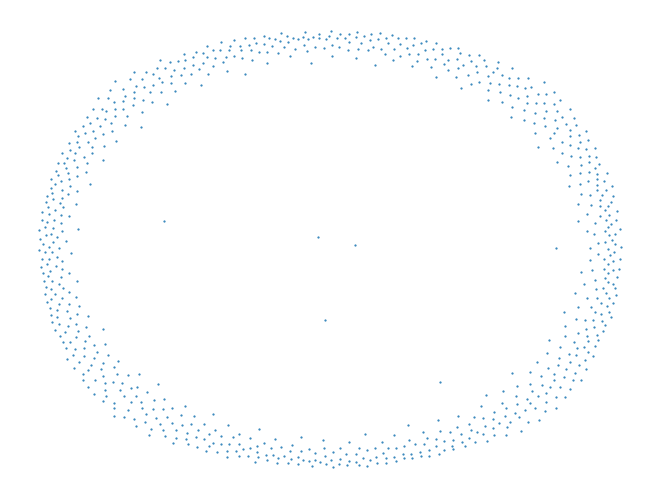

In [85]:
seed = 20160
G_umbral_null = nx.from_numpy_matrix(fb_E_null) 
pos = nx.spring_layout(G_umbral_null, seed=seed)  # Seed for reproducible layout
nx.draw(G_umbral_null, pos, node_size=0.3)
plt.savefig("graficos/relaciones-umbral-ninguno.svg", format="SVG")

Pareciera ser que hay una gran cantidad de nodos que se relacionan entre sí. Esto viendo el grafo.

Con esta nueva matriz definida, buscamos las similaridades. Para ello definimos varios métodos nuevos.
El primer método consiste en buscar la maxima correlacion entre ambas matrices. Para ello se usa un _flatten_ que hace que todas las filas se concatenen generando un vector. El _flatten_ lo usamos en ambas matrices, adyacencia y similaridad y posteriormente, le calculamos la maxima correlación.

In [62]:
def buscar_correlaciones(mat_similaridad, mat_adyacencia, max_attrs):
    adyacencia_estirada = mat_adyacencia.flatten()
    resultados = []
    for num in range(0, max_attrs+1):
        estimado = estimar_facebook(mat_similaridad, num)
        cor = correlacion(estimado.flatten(), adyacencia_estirada)
        resultados.append([num, cor])
    return resultados

Otro método es contar la similitudes que hay en la matriz, para cierto valor

In [63]:
def contar_similitudes(mat_fb, mat_adyacencia):
    c = 0
    for i in range(0, len(mat_fb)):
        for j in range(0, len(mat_fb)):
            if mat_fb[i][j] == mat_adyacencia[i][j]: c+=1
    return c

Y buscamos las similitudes

In [64]:
def buscar_similitudes(mat_similaridad, mat_adyacencia, max_attrs):
    resultados = []
    for num in range(0, max_attrs+1):
        similitud = contar_similitudes(estimar_facebook(mat_similaridad, num), mat_adyacencia)/len(mat_similaridad)**2
        resultados.append([num, similitud])
    return resultados

Los resultados obtenidos son:

In [65]:
correlaciones_l = buscar_correlaciones(fb_similaridad, M_ady, 22)

In [66]:
similitudes_l = buscar_similitudes(fb_similaridad, M_ady, 22)

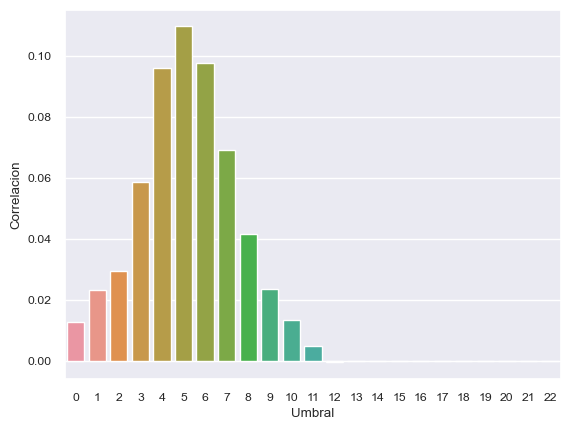

In [67]:
df_correlaciones_sim = pd.DataFrame(correlaciones_l, columns=["Umbral", "Correlacion"]);

name = F"Correlaciones de Similaridad para varios umbrales"

sns.set(font_scale = 0.8)
fig = sns.barplot(
    data=df_correlaciones_sim, 
    x='Umbral', 
    y='Correlacion'
);

fig.set(xlabel='Umbral', ylabel='Correlacion');
plt.savefig("graficos/correlacion_similaridad.svg", bbox_inches = 'tight');

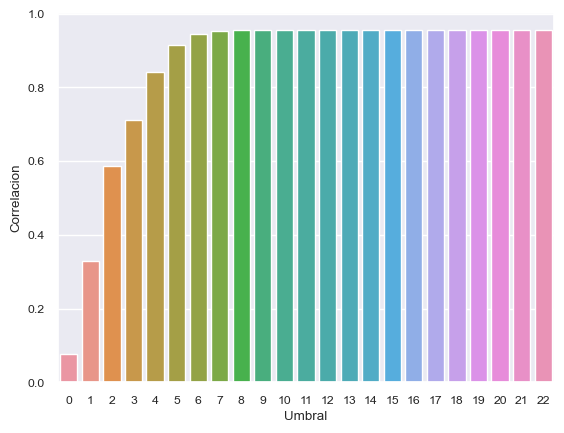

In [68]:
df_similitudes_sim = pd.DataFrame(similitudes_l, columns=["Umbral", "Correlacion"]);

name = F"Correlaciones de Similaridad para varios umbrales"

sns.set(font_scale = 0.8)
fig = sns.barplot(
    data=df_similitudes_sim, 
    x='Umbral', 
    y='Correlacion'
);

fig.set(xlabel='Umbral', ylabel='Correlacion');
plt.savefig("graficos/similitudes_similaridad.svg", bbox_inches = 'tight');

Ambas búsquedas divergen, cosa que no tiene mucho sentido. Pero si usamos la noción común, sería entendible que mientras más gustos en común se puedan llevar mejor 2 personas pero, entre muchos usuarios, es poco común que la gran mayoria tenga, en este caso, 22 gustos. No tendría mucho sentido. Por tal motivo, nos quedamos con la de correlaciones que, a simple vista y en base a la intuición es el que mejor funciona.
A demás, a partir del umbral 7 en adelante, todos los resultados de correlación son practicamente similares.

Con esto en cuenta podemos decir que una buena medida para decir que dos personas son amigas entre sí es que compartan entre 4 o 6 atributos, siendo el mejor umbral el de 5 atributos.

Procedo a calcular la matriz con umbral 5 y armar el grafo que le representa

In [69]:
fb_E_ideal = estimar_facebook(fb_similaridad, 5)

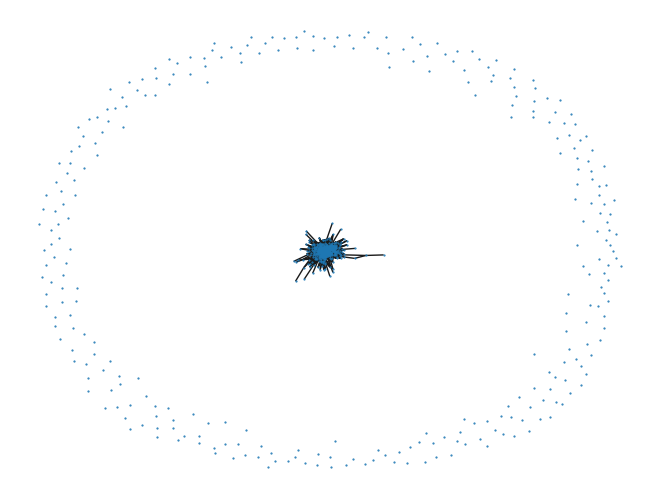

In [70]:
seed = 20160
G_ideal = nx.from_numpy_matrix(fb_E_ideal) 
pos = nx.spring_layout(G_ideal, seed=seed)  # Seed for reproducible layout
nx.draw(G_ideal, pos, node_size=0.3)
plt.savefig("graficos/relaciones_umbral_ideal.png", format="PNG")

Armamos la matriz de adyacencias reales

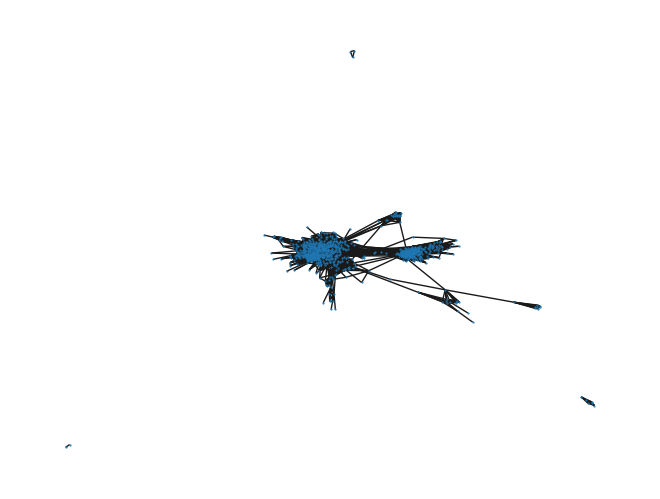

In [80]:
seed = 20160
G_ady = nx.from_numpy_matrix(M_ady) 
pos = nx.spring_layout(G_ady, seed=seed)  # Seed for reproducible layout
nx.draw(G_ady, pos, node_size=0.3)
plt.savefig("graficos/relaciones_reales.png", format="PNG")

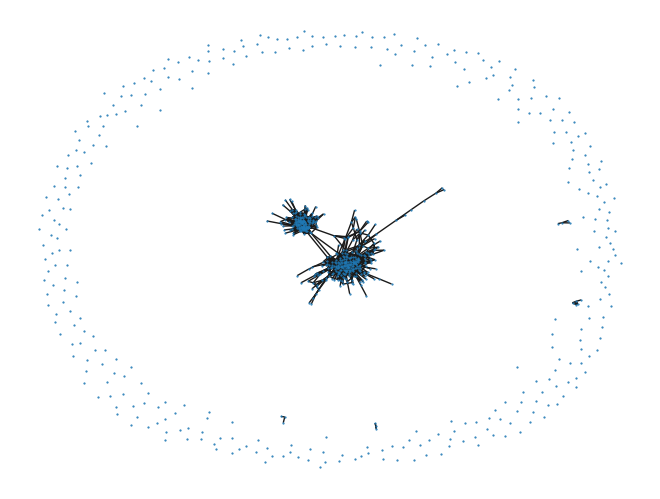

In [81]:
seed = 20160
GH_intersection = nx.intersection(G_ideal, G_ady)
pos = nx.spring_layout(GH_intersection, seed=seed)
nx.draw(GH_intersection, pos, node_size=0.3)
plt.savefig("graficos/relaciones_interseccion.png", format="PNG")

Vamos ahora a hacer el calculo de componentes principales

In [90]:
(X, C) = matriz_covarianza(atributos)

In [91]:
# Convertimos la de componentes principales en un .txt para,
# posteriormente ejecutar el algoritmo del metodo de la potencia y obtener los valores buscados.
imprimir_matriz(path_egofacebook, "componentes.txt", C)

# Ejecutamos el metodo de la potencia con deflación
#correr_metodo_potencia(F"{path_egofacebook}/componentes.txt", 1000, 1e-6)

# Obtenemos autovalores y autovectores
eigenvalues_componentes = leer_columna_matriz(F"{path_egofacebook}/componentes.txt-autovalores.out")
eigenvectors_componentes = leer_matriz_columnas(F"{path_egofacebook}/componentes.txt-autovectores.out")

In [92]:
# Tengo que armar la matriz
V = np.zeros(eigenvectors_componentes.shape)
for i in range(0, len(eigenvectors_componentes[0])):
    for j in range(0, len(eigenvectors_componentes)):
        V[i][j] = eigenvectors_componentes[j][i]
VT = V.T
D = np.zeros(eigenvectors_componentes.shape)
for i in range(0, len(eigenvalues_componentes)):
    D[i][i] = eigenvalues_componentes[i]

C_N = V @ D @ VT

Tengo la descomposición, ahora lo que tengo que hacer es probar distintos k y para los mismos proponer varios umbrales para cada uno. Para tal motivo, los distintos valores de $k$ se basarán en la cantidad de autovalores y repetiremos los umbrales hechos en los puntos previos, desde 0 hasta 23, y con eso sacaremos diversas conclusiones.

In [96]:
eigen_num = len(eigenvalues_componentes)
resultados_componentes = []
for k in range(1, eigen_num):
    clear_output(wait=True)
    display('K componentes principales: ' + str(k))
    # Selecciono k componentes principales de VT y hago el producto VT*X
    V_AUX = V[:,:k]
    VTX = X @ V_AUX
    # Con esa matriz resultante calculo la matriz de similaridad
    SIM_AUX = matriz_similaridad(VTX)
    # Ahora corro el metodo para buscar correlaciones
    correlaciones_aux = buscar_correlaciones(SIM_AUX, M_ady, 22)
    resultados_componentes.append([k, correlaciones_aux])

'K componentes principales: 785'

Obtenidos todos los valores, buscamos el de máxima correlación con mejor $k$ componentes

In [143]:
besto_k = resultados_componentes[0][0]
besto_val = resultados_componentes[0][1][0]

In [144]:
print(besto_val)

[0, -0.009890435463618247]


In [145]:
for i in range(0, len(resultados_componentes)):
    k_valor = resultados_componentes[i][0]
    arr_valor = resultados_componentes[i][1]
    for j in range(0, len(arr_valor)):
        value = arr_valor[j]
        if value[1] > 0:
            if value[1] > besto_val[1]:
                besto_k = k_valor
                besto_val = value

In [157]:
print(F"K componentes: {besto_k}")
print(F"Con umbral y correlación: {besto_val}")

K componentes: 696
Con umbral y correlación: [0, 0.0025651775330753825]


Los resultados dan que la mejor correlación es con 696 componentes principales y umbral 0. Extraño pero bueno. Veamos el grafo resultante

In [154]:
# Selecciono k componentes principales de VT y hago el producto VT*X
V_IDEAL = V[:,:besto_k]
VTX_IDEAL = X @ V_AUX
# Con esa matriz resultante calculo la matriz de similaridad
SIM_AUX_IDEAL = matriz_similaridad(VTX_IDEAL)

# Ahora estimo la matriz con ese umbral
umbral_componentes = besto_val[0]
fb_E_IDEAL_componentes = estimar_facebook(SIM_AUX_IDEAL, umbral_componentes)

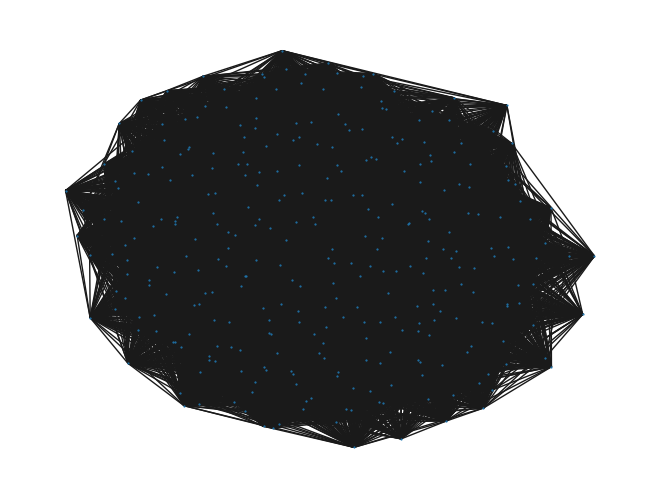

In [155]:
seed = 20160
G_ideal_componentes = nx.from_numpy_matrix(fb_E_IDEAL_componentes) 
pos = nx.spring_layout(G_ideal_componentes, seed=seed)  # Seed for reproducible layout
nx.draw(G_ideal_componentes, pos, node_size=0.3)
plt.savefig("graficos/relaciones_ideal_componentes.png", format="png")